In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Consider the task of an agent maneuvering to a goal state in a maze. The agent has four possible actions: North, South, East, West. When the agent takes an action, it moves to the adjacent state in the chosen direction with probability 0.70, and in one of the other directions with probability 0.30 spread evenly. For example, if the agent chooses North, then there is a 70% chance that it actually moves North, a 10% chance it will move South, 10% it will move West, and 10% it will move East. If the agent moves in a direction that will take it outside the maze (e.g. moving South in S), it stays in the same state. The reward r is 0 for all state transitions, except that when entering the goal state G the reward is 10.0. The discount factor $\gamma$ is set to 0.9. The agent cannot leave the goal state.

In [2]:
E = EMPTY = 0
B = BLOCKED = 1
G = GOAL = 2

# The maze from the assignment
MAZE = np.array(
    [[0, 0, 0, 0, 0, 0, 0],
     [0, 0, B, 0, 0, 0, 0],
     [0, B, B, 0, 0, 0, 0],
     [0, 0, B, 0, 0, B, 0],
     [0, 0, 0, 0, 0, B, G]])

In [3]:
def plot_values(values):
    plt.xlim([0,7])
    plt.ylim([5,0])
    for x in range(values.shape[0]):
        for y in range(values.shape[1]):
            plt.text(y + 0.5, x + 0.5, '%.2f' % values[x, y],
                         horizontalalignment='center',verticalalignment='center')
    plt.show()

In [4]:
def plot_policy(policy):
    plt.xlim([0,7])
    plt.ylim([5,0])
    for x in range(policy.shape[0]):
        for y in range(policy.shape[1]):
            plt.text(y + 0.5, x + 0.5, '%s' % policy[x, y],
                         horizontalalignment='center',verticalalignment='center')
    plt.show()

In [5]:
def plot_directions(policy):
    plt.xlim([0,7])
    plt.ylim([5,0])
    for x in range(policy.shape[0]):
        for y in range(policy.shape[1]):
            if MAZE[x,y] == 1:
                plt.gca().add_patch(plt.Polygon([[y-0.01,x-0.01],[y+1+0.01,x-0.01],[y+1+0.01,x+1+0.01],[y-0.01,x+1+0.01]],color="k"))
            coordinates = (y+0.5,x+0.5)
            if policy[x,y]==1:
                length = (0.3,0)
            if policy[x,y]==3:
                length = (-0.3,0)
            if policy[x,y]==0:
                length = (0,-0.3)
            if policy[x,y]==2:
                length = (0,0.3)
            plt.arrow(coordinates[0],coordinates[1],length[0],length[1],color="k",head_width=0.1, head_length=0.1, fc='k', ec='k')
    plt.show()

A visualization of our Grid World (Gray is wall, White is the GOAL state and Black are all the other possible state a robot can be in)

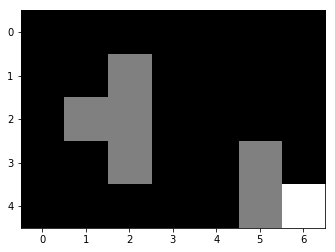

In [6]:
plt.imshow(MAZE, interpolation='nearest', cmap='gray')

In [7]:
# The possible actions
ACTIONS = np.array(['N', 'E', 'S', 'W'])
ACTION_IDX = {a: idx for idx, a in enumerate(ACTIONS)}

In [8]:
# transition probabilities given a specific action to one of the 5 outcomes.
# probabilties for [staying, N, E, S, W]
ACTION_PROBS = {
    ACTIONS[0]: [0.0, 0.7, 0.1, 0.1, 0.1],
    ACTIONS[1]: [0.0, 0.1, 0.7, 0.1, 0.1],
    ACTIONS[2]: [0.0, 0.1, 0.1, 0.7, 0.1],
    ACTIONS[3]: [0.0, 0.1, 0.1, 0.1, 0.7]
}

In [9]:
def get_neighbours(state):
    """ Return a list of all four neighbour states and the current position. """
    row, col = state
    return [
        (row,   col),    # -
        (row-1, col),    # N
        (row,   col+1),  # E
        (row+1, col),    # S
        (row,   col-1),  # W
    ]

In [10]:
def is_in_maze(state):
    """ Return True if position is inside the maze and not blocked. """
    R, C = MAZE.shape
    row, col = state
    return (0 <= row < R) and (0 <= col < C) and MAZE[state] != BLOCKED

In [11]:
def state_prob(s, s2, a):
    """ Return the probability of transitioning from s to s2 by action a. """
    assert is_in_maze(s)
    assert a in ACTIONS
    neighbours = get_neighbours(s)
    assert s2 in neighbours

    if MAZE[s] == GOAL:
        return 1.0 if s == s2 else 0.0

    # copy action a transition probabilities
    pr = list(ACTION_PROBS[a])

    # fall back to s if you can't go to a specific neighbour.
    for i, n in enumerate(neighbours):
        if not is_in_maze(n):
        	# illegal neighbour, move probabilities to staying. 
            pr[0] += pr[i]
            # reset the probability of the illegal move to staying (sum of all 5 paths equals 1 again)
            pr[i]  = 0

    # return probability for the target state
    return pr[neighbours.index(s2)]

In [12]:
def get_all_states():
    """ 
    Return a generator to iterate over all possible states.
    Can be used like this: 
    for s in get_all_states():
        (do something with s)
    """
    for x in range(MAZE.shape[0]):
        for y in range(MAZE.shape[1]):
            if is_in_maze((x, y)):
                yield (x, y)

PART 1: Solve the Grid World problem by Policy Iteration

In [13]:
def reward(s, s2, a):
    """ Return the reward for taking action a in state s and ending up in s2. """
    # if s2 is GOAL state and we are not already in the GOAL state
    if s != s2 and MAZE[s2] == GOAL:
        return 10.0
    else:
        return 0.0

In [14]:
def value_backup(policy, s, V, discount=0.9):
    """ 
    Compute and return the new value only for state s using the current values V and the current policy.
    The value backup is related to policy evaluation (see slides 37).
    """
    v = 0
    for a in ACTIONS:
        for s2 in get_neighbours(s):
            # check whether is s2 is a possible state
            if is_in_maze(s2):
                v += policy[s[0], s[1], ACTION_IDX[a]] * state_prob(s, s2, a) * (reward(s, s2, a) + discount * V[s2])
    return v

In [15]:
def policy_evaluation(policy, discount=0.9, epsilon=1e-9):
    """ 
    Iteratively computes the values of each state following a specific policy.
    The starting values for each state should be 0 when evaluating a new policy!
    Stop the iterative procedure if no state has a bigger change than epsilon. 
    Returns the final values for each state.
    """
    V = np.zeros_like(MAZE, dtype=np.float64)
    # We need difference between the values of V[s] before and after an iteration
    diff = epsilon + 1 # We initialize this difference to a value that is more than epsilon in order to start the loop
    while epsilon < diff:
        diff=0
        for s in get_all_states():
            V_old = V[s]
            V[s] = value_backup(policy, s, V, discount)
            diff = max(abs(V[s]-V_old), diff)
    return V

In [16]:
def policy_improvement(policy, V, discount=0.9):
    """ 
    Update the policy by greedily choosing actions based on the current values of states.
    Returns the new policy
    """
    # Now we run the Bellman Expectation Equation but aggregate the values at the level of actions
    for s in get_all_states():
        action_values = np.zeros(len(ACTIONS))
        for a in ACTIONS:
            for s2 in get_neighbours(s):
                if is_in_maze(s2):
                    action_values[ACTION_IDX[a]] += policy[s[0], s[1], ACTION_IDX[a]] * state_prob(s, s2, a) * (reward(s, s2, a) + discount * V[s2])
        
        policy[s[0], s[1]] = 0.0
        policy[s[0], s[1], np.argmax(action_values)] = 1.0
        
    return policy

In [17]:
def policy_iteration(discount=0.9):
    """ 
    Use a random starting policy and iteratively improve it until it is converged.
    Use the functions policy_evaluation and policy_iteration when implementing this function.
    If you copy numpy array make sure to copy by value use np.copy()
    Returns the converged policy and the final values of each state.
    """
    # init random policy
    policy = 1/len(ACTIONS) * np.ones((MAZE.shape[0], MAZE.shape[1], len(ACTIONS)))
    
    # policy iteration
    while True:
        policy_old = np.copy(policy)
        
        V = policy_evaluation(policy, discount, epsilon=1e-9)
        policy = policy_improvement(policy, V, discount)
        
        if np.array_equal(policy, policy_old):
            break
    return policy, V

In [18]:
policy, V = policy_iteration(discount=0.9)

print('Value Function:')
print(np.round(V, decimals=2))

print('Optimal Policy:')
print(ACTIONS[np.argmax(policy, 2)])

Value Function:
[[ 2.11  2.49  2.99  3.54  4.11  4.76  5.5 ]
 [ 1.83  2.11  0.    4.03  4.68  5.51  6.47]
 [ 1.6   0.    0.    4.43  5.28  6.45  7.78]
 [ 1.72  1.97  0.    3.83  4.41  0.    9.39]
 [ 1.97  2.32  2.79  3.3   3.75  0.    0.  ]]
Optimal Policy:
[['E' 'E' 'E' 'E' 'E' 'S' 'S']
 ['E' 'N' 'N' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'E' 'E' 'E' 'S']
 ['S' 'S' 'N' 'N' 'N' 'N' 'S']
 ['E' 'E' 'E' 'N' 'N' 'N' 'N']]


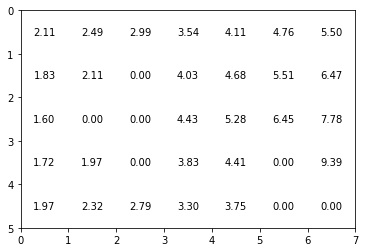

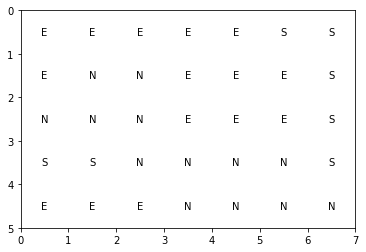

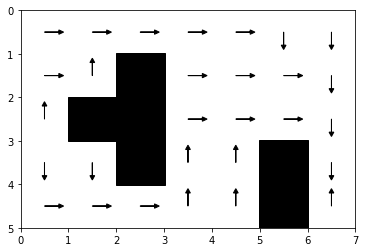

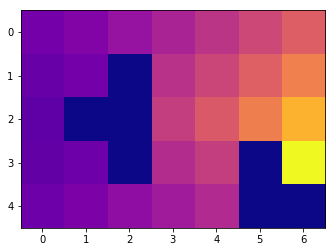

In [19]:
plot_values(V)
plot_policy(ACTIONS[np.argmax(policy, 2)])
plot_directions(np.argmax(policy, 2))
plt.imshow(V, interpolation='nearest', cmap='plasma')

In [20]:
policy2, V2 = policy_iteration(discount=0.7)

print('Value Function:')
print(np.round(V2, decimals=2))

print('Optimal Policy:')
print(ACTIONS[np.argmax(policy, 2)])

Value Function:
[[ 0.09  0.15  0.26  0.44  0.7   1.1   1.72]
 [ 0.06  0.09  0.    0.67  1.07  1.75  2.86]
 [ 0.04  0.    0.    0.94  1.6   2.85  4.93]
 [ 0.05  0.08  0.    0.59  0.93  0.    8.54]
 [ 0.08  0.13  0.22  0.37  0.56  0.    0.  ]]
Optimal Policy:
[['E' 'E' 'E' 'E' 'E' 'S' 'S']
 ['E' 'N' 'N' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'E' 'E' 'E' 'S']
 ['S' 'S' 'N' 'N' 'N' 'N' 'S']
 ['E' 'E' 'E' 'N' 'N' 'N' 'N']]


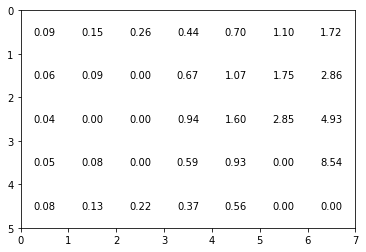

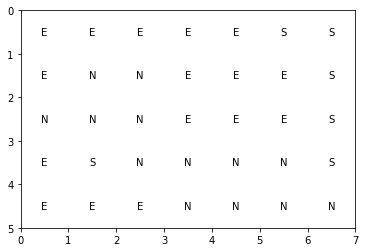

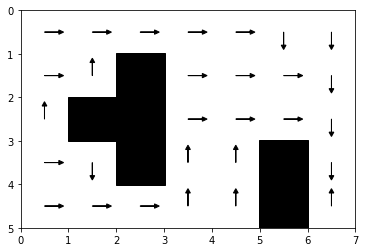

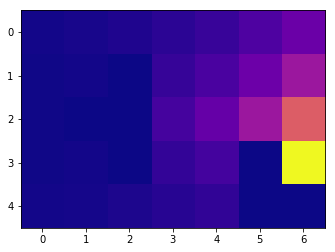

In [21]:
plot_values(V2)
plot_policy(ACTIONS[np.argmax(policy2, 2)])
plot_directions(np.argmax(policy2, 2))
plt.imshow(V2, interpolation='nearest', cmap='plasma')

The following are the plots of difference between the values of V and V2. This is done to study the effects of change int he gamma value

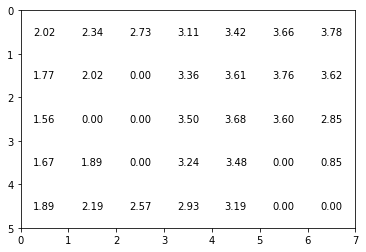

In [22]:
plot_values(V - V2)

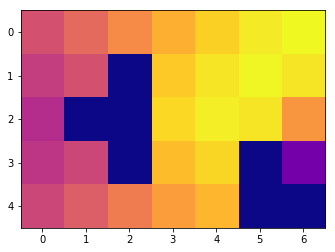

In [23]:
plt.imshow(V - V2, interpolation='nearest', cmap='plasma')

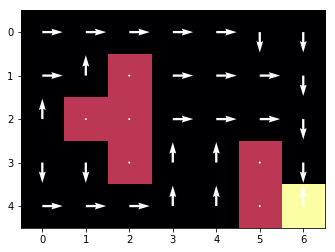

In [24]:
#Another way to plot
plt.imshow(MAZE,interpolation='nearest', cmap='inferno')
U = policy[:,:,0] - policy[:,:,2]
V = policy[:,:,1] - policy[:,:,3]
plt.quiver(V,U,color='w')
plt.show()

Part 2: Solve the Grid World problem by Q-Learning

In [25]:
START_STATE = (1, 1)

In [26]:
def sample_state(s, a):
    """ Starting from state s and using action a randomly sample the next state. """
    #neighbours = [n for n in get_neighbours(s) if is_in_maze(n)]
    neighbours = []
    for neighbour in get_neighbours(s):
        if is_in_maze(neighbour):
            neighbours.append(neighbour)
    #print(neighbours)
    #F = np.cumsum([state_prob(s, s2, a) for s2 in neighbours])
    probs = []
    for s2 in neighbours:
        probs.append(state_prob(s, s2, a))
    probs = np.cumsum(probs)
    rnd = np.random.uniform()
    index = 0
    for idx, prob in enumerate(probs):
        if prob < rnd:
            index = idx+1
    neighbour = neighbours[index]
    return neighbour

In [27]:
sample_state((1,1), 'E')

(1, 1)

In [28]:
def TD_backup(Q, s1, s2, a, discount, alpha):
    """ 
    Computes the new state-action value based on the s1,a,s2 transition.
    Similar to the value_backup function. 
    """
    rew = reward(s1, s2, a)
    index = (s1[0], s1[1], ACTION_IDX[a])
    Q[index] = Q[index] + alpha * ((rew + discount * np.max(Q[s2])) - Q[index])

In [29]:
def epsilon_greedy(q, epsilon):
    """ 
    Select and return the action according to the epsilon-greedy policy.
    Greedy exploration in model-free RL doesn't cover the full possible state space. 
    """
    prob = np.random.uniform()
    if 1 - epsilon <= prob:
        action = np.random.choice(ACTIONS)
    else:
        max_value = np.max(q)
        action = np.random.choice(ACTIONS[q==np.max(q)])
        #action = np.random.choice(ACTIONS[np.argmax(q)]) #incorrect
    return action

In [30]:
def run_episode(Q, max_steps=100, discount=0.9, alpha=0.4, epsilon=0.05):
    """
    Run a single episode starting from the start_state position until the agent reaches the goal.
    Returns the accumulated reward. 
    Make use of the already existing functions like epsilon_greedy, sample_state, reward, and TD_backup.
    """
    episode_reward = 0
    step = 0
    CURRENT_STATE = START_STATE
    while MAZE[CURRENT_STATE] != GOAL and step < max_steps:
        action = epsilon_greedy(Q[CURRENT_STATE], epsilon)
        NEXT_STATE = sample_state(CURRENT_STATE, action)
        TD_backup(Q, CURRENT_STATE, NEXT_STATE, action, discount, alpha)
        episode_reward += reward(CURRENT_STATE, NEXT_STATE, action)
        step += 1
        CURRENT_STATE = NEXT_STATE
    return episode_reward

In [31]:
def q_learning(episodes):
    """ 
    Learns the Q values for the given MAZE environment with Q-Learning using a number of episodes and 
    returns Q, the total_reward over all episodes, and the reward each episode.
    """
    Q = np.zeros((MAZE.shape[0], MAZE.shape[1], ACTIONS.shape[0])) 
    total_reward = 0
    reward_over_time = []
    for i in range(episodes):
        reward_over_time.append(total_reward)
        total_reward += run_episode(Q)
    return Q, total_reward, reward_over_time

In [32]:
Q, total_reward, reward_over_time = q_learning(1000)

In [33]:
Q.max(axis=2)

array([[  1.85008575e+00,   2.31437823e+00,   2.75355825e+00,
          3.69560985e+00,   4.38781971e+00,   5.32827133e+00,
          4.34717981e+00],
       [  1.59689165e+00,   1.94954179e+00,   0.00000000e+00,
          3.75363611e+00,   4.64206677e+00,   6.44581115e+00,
          7.52934553e+00],
       [  1.39610053e+00,   0.00000000e+00,   0.00000000e+00,
          4.63107216e+00,   6.34969177e+00,   7.54851799e+00,
          8.56491058e+00],
       [  1.68317880e-01,   7.02015947e-03,   0.00000000e+00,
          3.60263314e+00,   4.12562540e+00,   0.00000000e+00,
          9.99922092e+00],
       [  1.33411168e-02,   1.18353971e-01,   9.64356485e-01,
          2.76264451e+00,   1.21234701e+00,   0.00000000e+00,
          0.00000000e+00]])

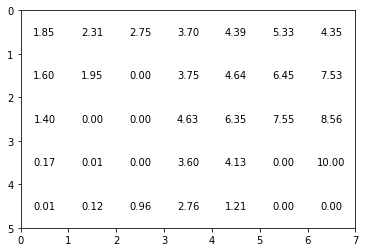

In [34]:
plot_values(Q.max(axis=2))

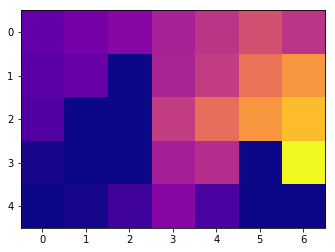

In [35]:
plt.imshow(Q.max(axis=2), interpolation='nearest', cmap='plasma')

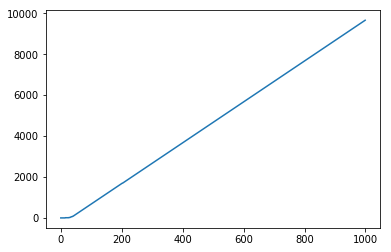

In [36]:
plt.plot(reward_over_time)

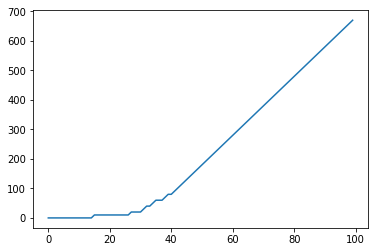

In [37]:
plt.plot(reward_over_time[:100])

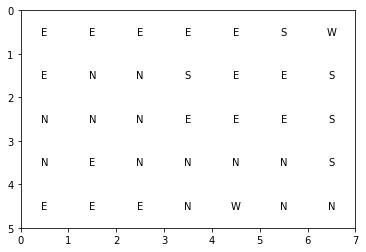

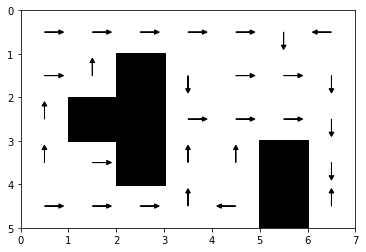

In [38]:
plot_policy(Q.argmax(axis=2).choose(ACTIONS))
plot_directions(Q.argmax(axis=2))